<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "6B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/6B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


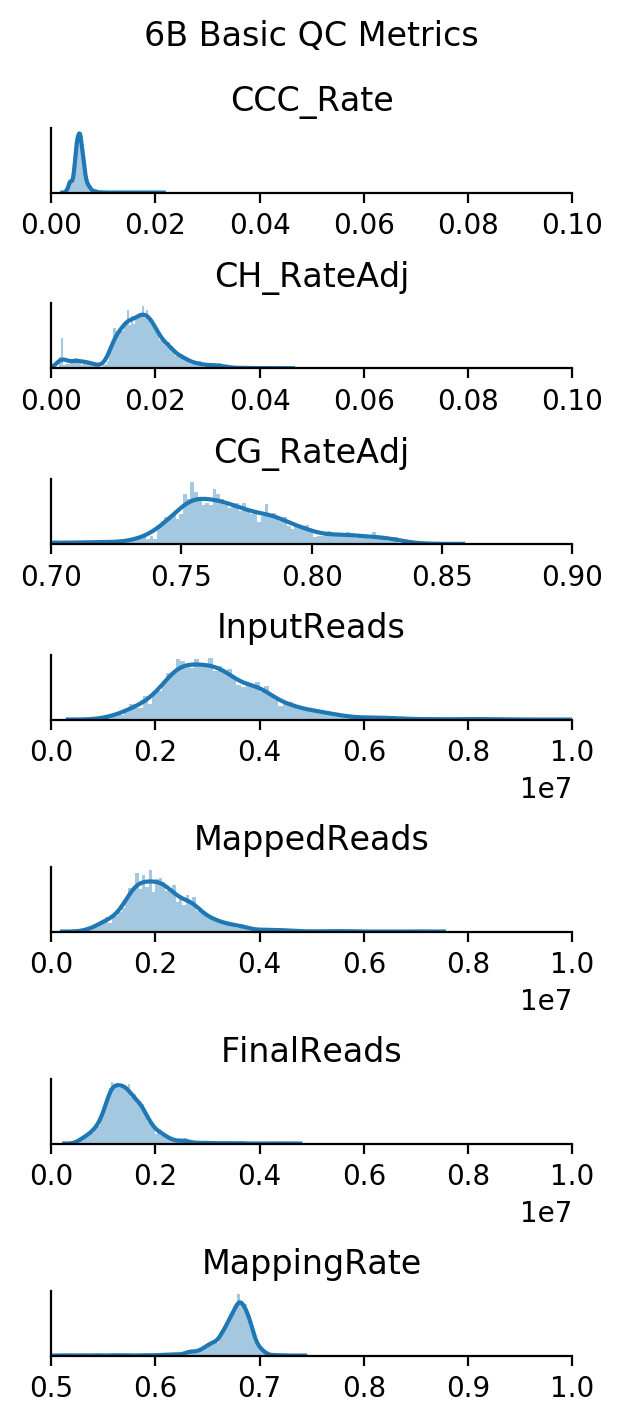

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

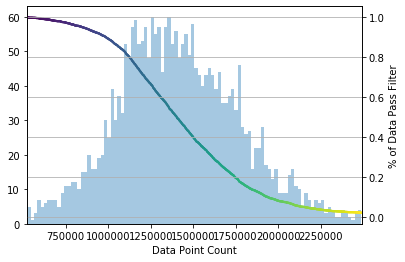

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2571/2571 (100.0%)
CG_RateAdj passed 2571/2571 (100.0%)
CH_RateAdj passed 2571/2571 (100.0%)
FinalReads passed 2571/2571 (100.0%)
MappingRate passed 2571/2571 (100.0%)
Overall passed 2571/2571 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
181022 1285
181023 1286


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 322 83.9%
ad002 322 83.9%
ad004 319 83.1%
ad006 326 84.9%
ad007 311 81.0%
ad008 330 85.9%
ad010 315 82.0%
ad012 326 84.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
6B_M_0,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-1...,0.005479,0.762580,0.761272,0.021888,0.016500,657531.0,1351316,849342.0,6B,...,15.633686,-6.369802,11.962666,-8.243307,IT-L6 Fstl4,-6.581370,-3.267274,1.193793,12.011250,True
6B_M_100,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-1...,0.004290,0.754953,0.753898,0.012955,0.008703,2129290.0,4323598,2986726.0,6B,...,-24.185396,-17.018791,-11.105342,-54.141211,CGE-Lamp5 Grid1,-8.919864,6.961700,10.817686,-14.813051,True
6B_M_1000,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.006056,0.828789,0.827746,0.027483,0.021557,1714896.0,3883192,2663342.0,6B,...,27.845894,2.012761,-0.802660,-30.255590,NP-L6 Cyp7b1,7.347579,6.011455,-30.909830,-5.318297,True
6B_M_1001,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.005838,0.766467,0.765095,0.024826,0.019100,1715562.0,3884332,2691763.0,6B,...,1.690343,-13.932268,-0.837965,38.681088,IT-L23 Cux1,-3.665571,6.772628,-5.440966,-16.530035,True
6B_M_1002,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.005677,0.770364,0.769053,0.023081,0.017504,1317286.0,3078328,2049789.0,6B,...,15.381865,-7.775118,0.408469,-2.356157,IT-L6 Man1c1,-3.098855,-9.905507,-18.863471,-24.849071,True
6B_M_1003,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.005011,0.758145,0.756927,0.019177,0.014237,1778841.0,4126178,2828034.0,6B,...,19.229633,4.899724,-52.233297,-13.479101,CT-L6 Il1rap,-12.027979,-14.983642,12.405291,33.563946,True
6B_M_1004,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.005128,0.761999,0.760772,0.019102,0.014046,1373931.0,3163230,2174757.0,6B,...,19.361609,5.083302,-51.069057,-14.077403,CT-L6 Il1rap,-12.000439,-15.148509,16.810242,32.592269,True
6B_M_1005,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.005473,0.789685,0.788528,0.023849,0.018477,1436992.0,3200082,2187298.0,6B,...,16.543427,-6.340632,9.273232,-5.918884,IT-L6 Cadps2,-5.183754,-4.829436,-8.694232,5.225767,True
6B_M_1007,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.005546,0.786876,0.785687,0.024548,0.019108,1860619.0,4328220,2898890.0,6B,...,-23.120846,-15.813757,-18.184961,-53.019694,CGE-Lamp5 Sorcs1,-13.124691,6.631424,19.961997,-17.928330,True
6B_M_1008,/gale/raidix/rdx-4/mapping/6B/CEMBA181022-6B-3...,0.004568,0.744889,0.743718,0.016650,0.012137,1961697.0,4562834,3052069.0,6B,...,6.596079,-18.496916,-47.756818,12.448966,IT-L4 Astn2,7.349273,3.400941,-29.277190,-14.981023,True
